# Store Sales Predication Using XG-Boost in Pyspark

In [3]:
import findspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [4]:
spark = SparkSession.builder.master("local").appName("Data Analytics On Retail Data").config("spark.some.config.option", "some-value").getOrCreate()

In [6]:
features=spark.read.csv('/content/Features data set.csv',header=True,inferSchema=True)
sales=spark.read.csv('/content/sales data-set.csv',header=True,inferSchema=True)
stores=spark.read.csv('/content/stores data-set.csv',header=True,inferSchema=True)

In [7]:
features.limit(5).show()
sales.show(5)
stores.show(5)

+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|Store|      Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday|
+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|    1|05/02/2010|      42.31|     2.572|       NA|       NA|       NA|       NA|       NA|211.0963582|       8.106|    false|
|    1|12/02/2010|      38.51|     2.548|       NA|       NA|       NA|       NA|       NA|211.2421698|       8.106|     true|
|    1|19/02/2010|      39.93|     2.514|       NA|       NA|       NA|       NA|       NA|211.2891429|       8.106|    false|
|    1|26/02/2010|      46.63|     2.561|       NA|       NA|       NA|       NA|       NA|211.3196429|       8.106|    false|
|    1|05/03/2010|       46.5|     2.625|       NA|       NA|       NA|       NA|       NA|211.3501429|       8

In [8]:
features.printSchema()
sales.printSchema()
stores.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- MarkDown1: string (nullable = true)
 |-- MarkDown2: string (nullable = true)
 |-- MarkDown3: string (nullable = true)
 |-- MarkDown4: string (nullable = true)
 |-- MarkDown5: string (nullable = true)
 |-- CPI: string (nullable = true)
 |-- Unemployment: string (nullable = true)
 |-- IsHoliday: boolean (nullable = true)

root
 |-- Store: integer (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)

root
 |-- Store: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)



### Data Formatting

In [9]:
col=to_date(features['Date'], 'dd/MM/yyyy').cast('date')
features1=features.withColumn('Date',col)
features2=features1.withColumn('year',year('Date'))

col_1=to_date(sales['Date'], 'dd/MM/yyyy').cast('date')
sales1=sales.withColumn('Date', col_1)
sales2=sales1.withColumn('year',year('Date'))

In [10]:
features2.show(3)
sales2.show(3)

+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+----+
|Store|      Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday|year|
+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+----+
|    1|2010-02-05|      42.31|     2.572|       NA|       NA|       NA|       NA|       NA|211.0963582|       8.106|    false|2010|
|    1|2010-02-12|      38.51|     2.548|       NA|       NA|       NA|       NA|       NA|211.2421698|       8.106|     true|2010|
|    1|2010-02-19|      39.93|     2.514|       NA|       NA|       NA|       NA|       NA|211.2891429|       8.106|    false|2010|
+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+----+
only showing top 3 rows

+-----+----+----------+------------+---------+----+

joining Sales & features DataSets...and selecting only 2010 data for 36 store alone.

In [27]:
df=sales2.join(features2, ['Date','Store','IsHoliday'], 'left_outer').drop(features2['year'])
df.show(2)

+----------+-----+---------+----+------------+----+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+
|      Date|Store|IsHoliday|Dept|Weekly_Sales|year|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|
+----------+-----+---------+----+------------+----+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+
|2010-02-05|    1|    false|   1|     24924.5|2010|      42.31|     2.572|       NA|       NA|       NA|       NA|       NA|211.0963582|       8.106|
|2010-02-12|    1|     true|   1|    46039.49|2010|      38.51|     2.548|       NA|       NA|       NA|       NA|       NA|211.2421698|       8.106|
+----------+-----+---------+----+------------+----+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+
only showing top 2 rows



In [28]:
# get the dimensions of the data
(df.count() , len(df.columns))

(421570, 15)

In [29]:
df=df.withColumn('MarkDown1', df['MarkDown1'].cast(IntegerType()))
df=df.withColumn('MarkDown2', df['MarkDown2'].cast(IntegerType()))
df=df.withColumn('MarkDown3', df['MarkDown3'].cast(IntegerType()))
df=df.withColumn('MarkDown4', df['MarkDown4'].cast(IntegerType()))
df=df.withColumn('MarkDown5', df['MarkDown5'].cast(IntegerType()))
df=df.withColumn('CPI', df['CPI'].cast(DoubleType()))
df=df.withColumn('Unemployment', df['Unemployment'].cast(DoubleType()))

In [30]:
df=df.withColumn('IsHoliday', df['IsHoliday'].cast(IntegerType()))

In [30]:
import pyspark.sql.functions as F

df=df.withColumn('Day',F.dayofweek('Date'))
df=df.withColumn('Month',month('Date'))

In [31]:
#missing value count
df.select([count(when(isnull(mshc),'mshc')).alias(mshc) for mshc in df.columns]).show()

+----+-----+---------+----+------------+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+
|Date|Store|IsHoliday|Dept|Weekly_Sales|year|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|CPI|Unemployment|
+----+-----+---------+----+------------+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+
|   0|    0|        0|   0|           0|   0|          0|         0|   270889|   310322|   284479|   286603|   270138|  0|           0|
+----+-----+---------+----+------------+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+



### Data Visualization

<Axes: xlabel='Store'>

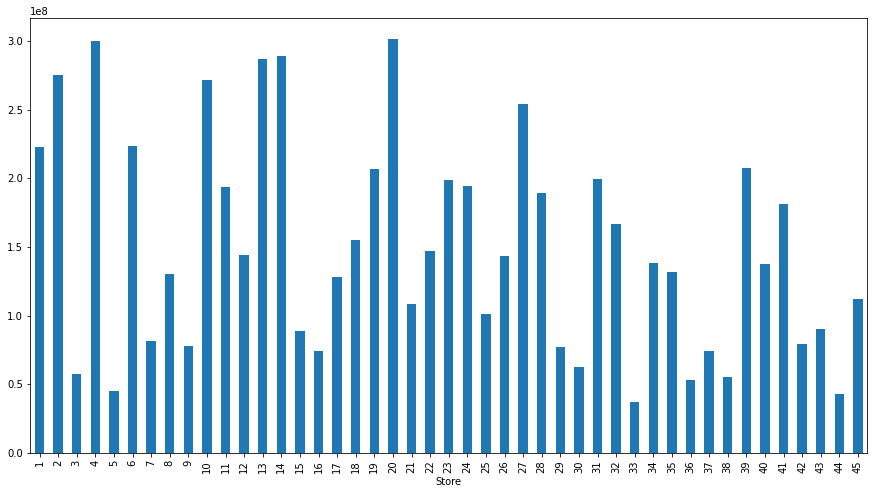

In [16]:
df_pd=df.toPandas()
df_pd.groupby('Store').Weekly_Sales.sum().plot.bar(figsize=(15,8))

<Axes: xlabel='year'>

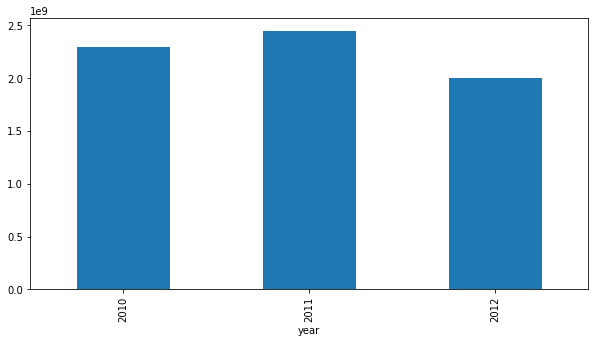

In [17]:
df_pd.groupby('year').Weekly_Sales.sum().plot.bar(figsize=(10,5))

<Axes: xlabel='Date', ylabel='Weekly_Sales'>

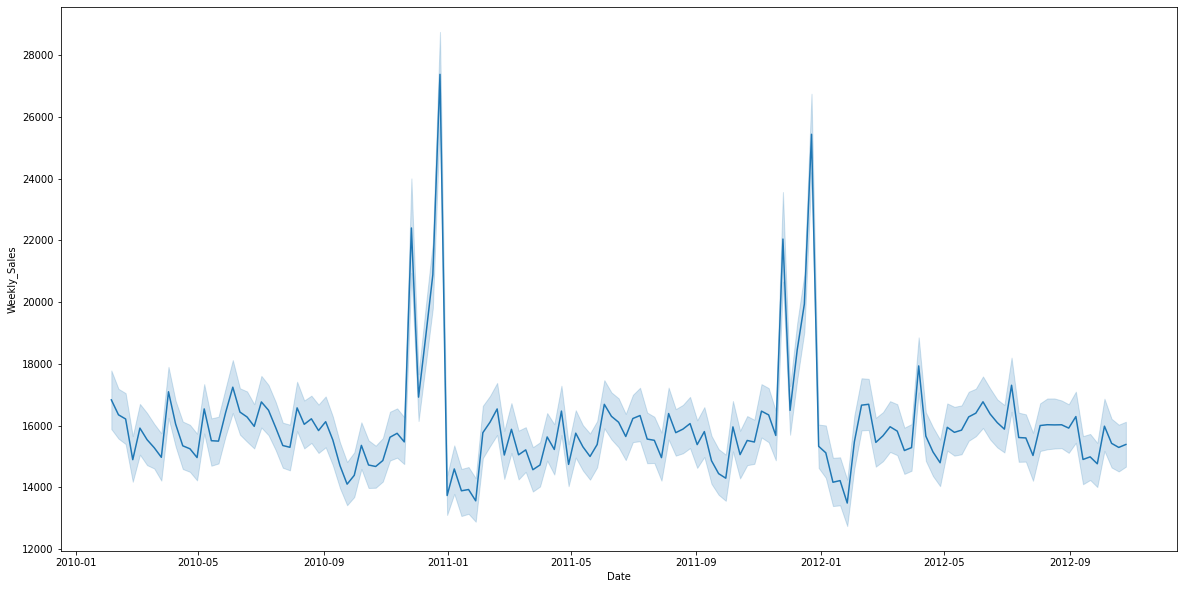

In [20]:
import seaborn as sns

plt.subplots(figsize=(20,10))
sns.lineplot(x='Date', y='Weekly_Sales', data=df_pd)

<Axes: xlabel='IsHoliday'>

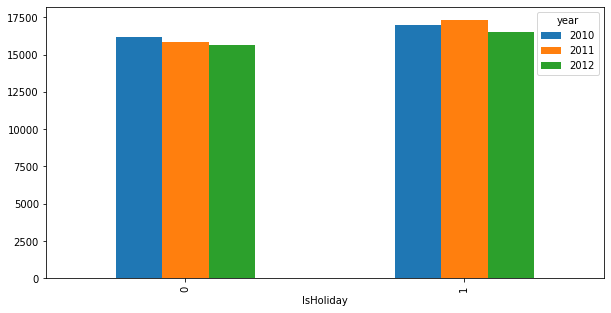

In [21]:
df_pd.groupby(['IsHoliday','year']).Weekly_Sales.mean().unstack('year').plot.bar(figsize=(10,5))

<Axes: xlabel='Store'>

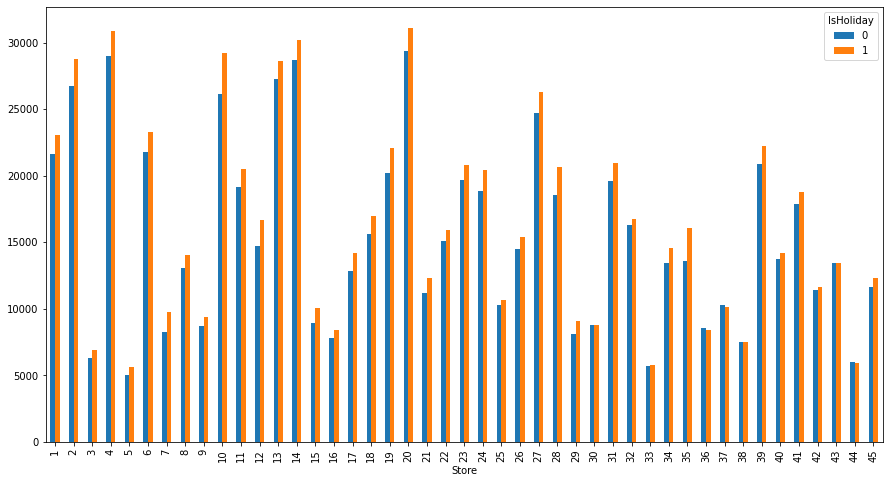

In [23]:
df_pd.groupby(['IsHoliday','Store']).Weekly_Sales.mean().unstack('IsHoliday').plot.bar(figsize=(15,8))

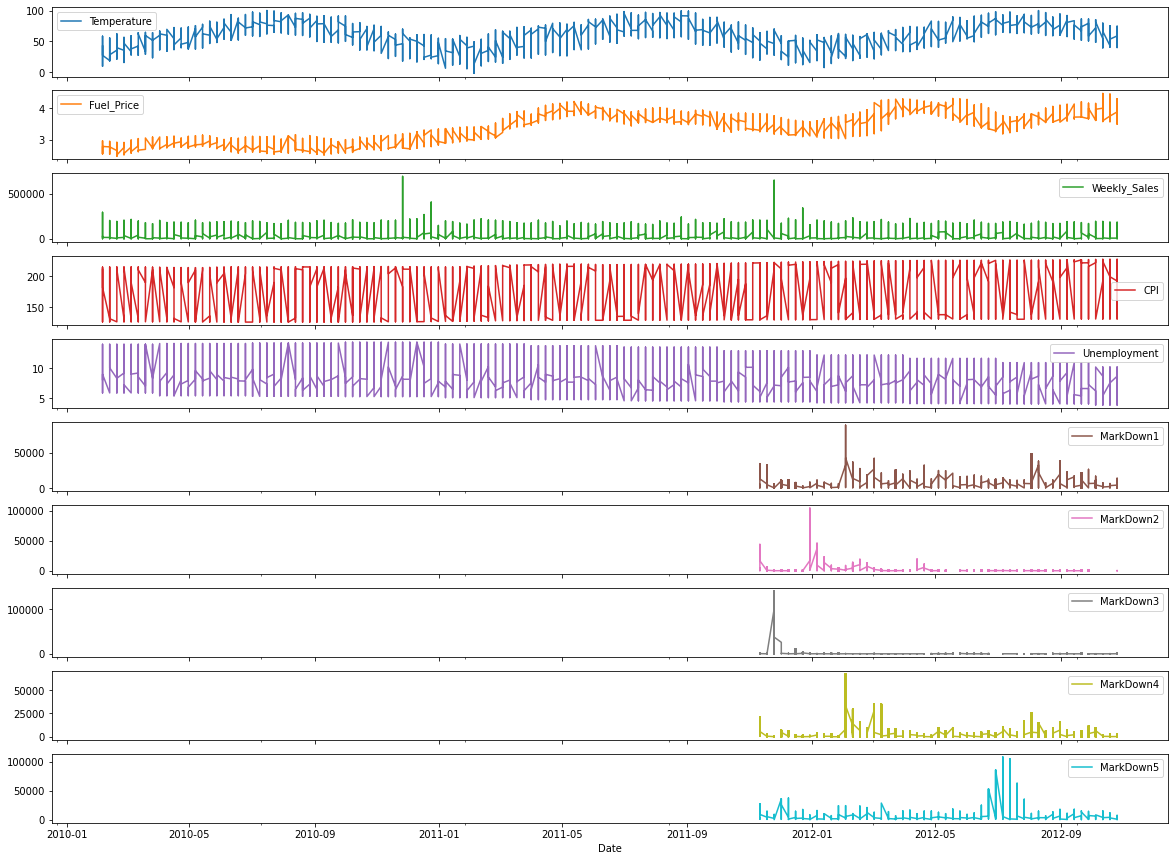

In [32]:
df_pd[['Date', 'Temperature', 'Fuel_Price', 'Weekly_Sales', 'CPI', 'Unemployment', 
    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].plot(x='Date', subplots=True, figsize=(20,15))
plt.show()

<Axes: >

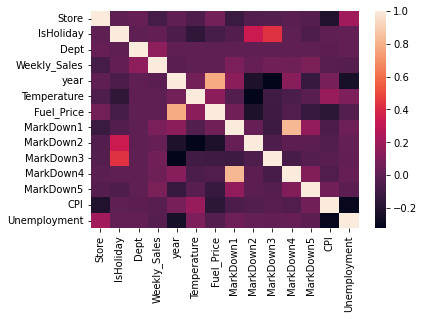

In [25]:
sns.heatmap(df_pd.corr())

### Box plot OF weekly_sales for each departmnet in Store number 36

<Axes: xlabel='Dept', ylabel='Weekly_Sales'>

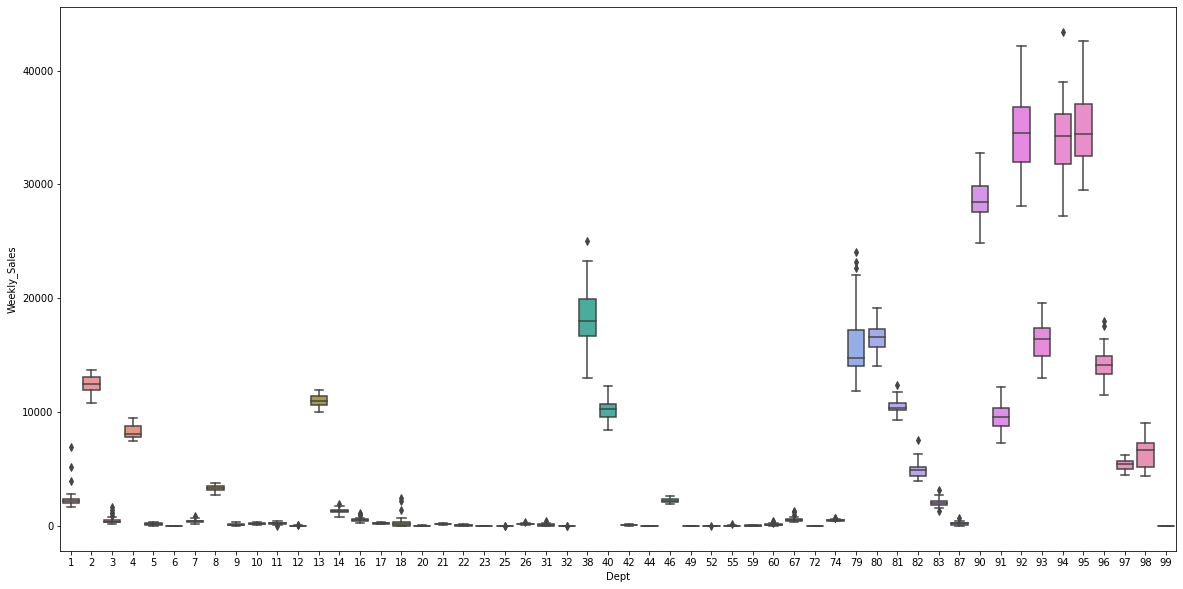

In [44]:
plt.subplots(figsize=(20,10))
sns.boxplot(x='Dept',y='Weekly_Sales',data=df36.toPandas())

In [119]:
df_join=stores.join(df, ['Store'],'left_outer').drop(df['Store'])

In [121]:
df_join.show(2)

+-----+----+------+----------+---------+----+------------+----+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---+-----+
|Store|Type|  Size|      Date|IsHoliday|Dept|Weekly_Sales|year|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|Day|Month|
+-----+----+------+----------+---------+----+------------+----+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---+-----+
|    1|   A|151315|2010-02-05|        0|   1|     24924.5|2010|      42.31|     2.572|     null|     null|     null|     null|     null|211.0963582|       8.106|  6|    2|
|    1|   A|151315|2010-02-12|        1|   1|    46039.49|2010|      38.51|     2.548|     null|     null|     null|     null|     null|211.2421698|       8.106|  6|    2|
+-----+----+------+----------+---------+----+------------+----+-----------+----------+---------+---------+---------+---------+---------+----

###  Adding more features to data by adding lags

In [122]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

windowSpec  = Window.partitionBy("Store").orderBy("Date")


In [123]:
from pyspark.sql.functions import lag    
df_final=df_join.withColumn("lag1",lag("Weekly_Sales",1).over(windowSpec)).withColumn("lag2",lag("Weekly_Sales",2).over(windowSpec)).withColumn("lag3",lag("Weekly_Sales",3).over(windowSpec)).withColumn("lag4",lag("Weekly_Sales",3).over(windowSpec)).withColumn("lag5",lag("Weekly_Sales",3).over(windowSpec))


### Preparation for Data Pipeline construction

In [124]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# create object of StringIndexer class and specify input and output column
SI_Type = StringIndexer(inputCol='Type',outputCol='Type_Index')

# # transform the data
# df_final = SI_Type.fit(df_final).transform(df_final)

# # view the transformed data
# df_final.select('Type', 'Type_Index').show(5)

In [125]:
from pyspark.ml.feature import VectorAssembler

# specify the input and output columns of the vector assembler
assembler = VectorAssembler(inputCols=['Store',
                                       'Type_Index',
                                       'Size', 
                                       'IsHoliday',
                                       'Dept',
                                       'year', 'Month', 'Day',
                                       'Temperature',
                                       'Fuel_Price',
                                       'MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5',
                                       'CPI','Unemployment',
                                       'lag1', 'lag2', 'lag3','lag4', 'lag5'],
                           outputCol='features')

# fill the null values
df_final = df_final.fillna(0)

# # transform the data
# final_data = assembler.transform(df_final)

# # view the transformed vector
# final_data.select('Weekly_Sales').show(5)

In [126]:
from pyspark.ml import Pipeline

# Make the pipeline
flights_pipe = Pipeline(stages=[SI_Type, assembler ])
piped_data = flights_pipe.fit(df_final).transform(df_final)

### Spliting Datset for modeling

In [127]:
# data splitting
training,testing = piped_data.randomSplit([.7, .3])

### prediction using Random Forest

In [128]:
from pyspark.ml.regression import RandomForestRegressor
# train our model using training data
dt = RandomForestRegressor(labelCol="Weekly_Sales", featuresCol="features")
model = dt.fit(training)
# test our model and make predictions using testing data
predictions = model.transform(testing)
predictions.select("prediction", "Weekly_Sales").show(5)

+------------------+------------+
|        prediction|Weekly_Sales|
+------------------+------------+
| 21511.48111771658|    21084.08|
| 21649.30805277665|    40129.01|
| 23221.31163376259|    16930.99|
|16776.249710621505|     8449.54|
|11761.889859768165|    13223.76|
+------------------+------------+
only showing top 5 rows



In [129]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder

In [130]:
def performance(predictions):
  eval = RegressionEvaluator(labelCol = 'Weekly_Sales')
  rmse = eval.evaluate(predictions)
  mse= eval.evaluate(predictions, {eval.metricName: 'mse'}) 
  print("MSE value: ", mse)
  mae= eval.evaluate(predictions, {eval.metricName: 'mae'})
  print("MAE value: ", mae)
  r2 = eval.evaluate(predictions, {eval.metricName: 'r2'})
  print("r2 valuse: ", r2)

In [131]:
performance(predictions)

MSE value:  257990642.95853594
MAE value:  10337.600106260184
r2 valuse:  0.49799956165855574


### Prediction using XGBoost

In [134]:
from xgboost.spark import SparkXGBRegressor
spark_reg_estimator = SparkXGBRegressor(
  features_col="features",
  label_col="Weekly_Sales",
)

In [135]:
xgb_regressor_model = spark_reg_estimator.fit(training)

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


In [136]:
# predict on test data
predictions= xgb_regressor_model.transform(testing)
predictions.select("prediction", "Weekly_Sales").show(5)

+----------------+------------+
|      prediction|Weekly_Sales|
+----------------+------------+
|  18364.91796875|    21084.08|
|    37029.859375|    40129.01|
| 24664.830078125|    16930.99|
| 6425.6669921875|     8449.54|
|12656.1904296875|    13223.76|
+----------------+------------+
only showing top 5 rows



In [137]:
performance(predictions)

MSE value:  29250326.62856412
MAE value:  2975.809481132015
r2 valuse:  0.9430844598827968


### Plot to Visualize Actaul Weekly_Sales and Predicted Sales Using XG-Boost

<Axes: xlabel='Date', ylabel='Weekly_Sales'>

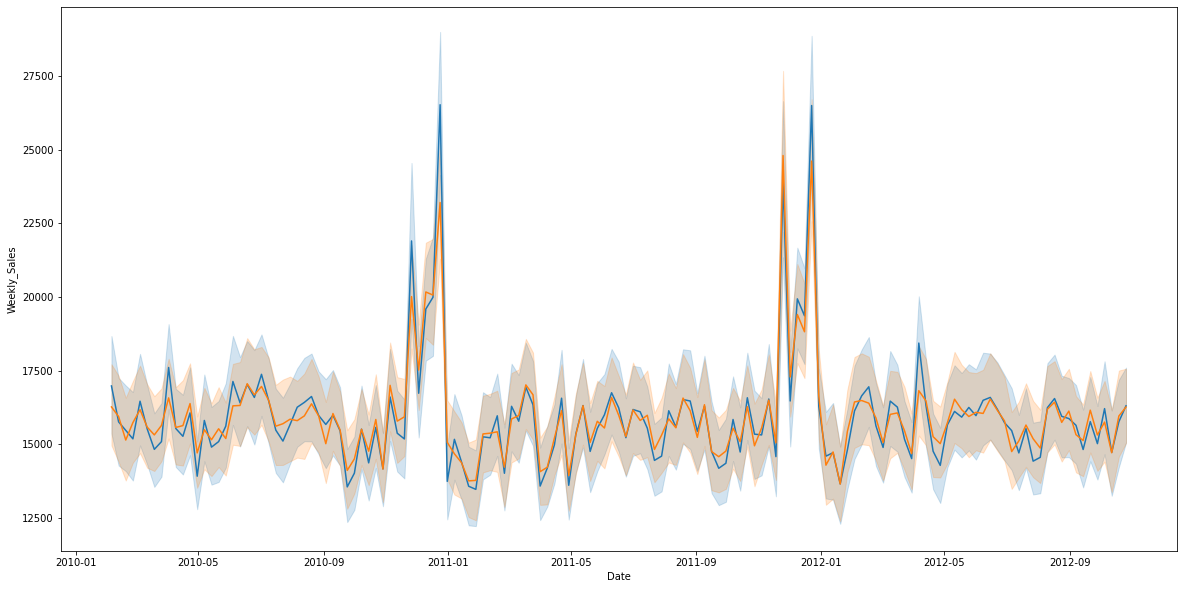

In [150]:
plt.subplots(figsize=(20,10))

sns.lineplot(x='Date', y='Weekly_Sales', data=predictions.toPandas())
sns.lineplot(x='Date', y='prediction', data=predictions.toPandas())